# Summary

The purpose of this notebook is to import data files extracted from the ACOEM handheld vibration device, and to visualize and analyze said data.

Note: the example `.asp` file examined below was from a reading on the U1 outboard generator bearing - next to the collector. The measurement was taken on March 3, 2023. A photo of the handheld's FFT was taken next to the results below on September 18, 2023 for comparison.


# Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sqlite3
import re
import numpy as np
import pandas as pd
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import matplotlib.pyplot as plt

In [5]:
# U1 OB Generator Bearing (orignial exploration was with these files):
dbfile = '/content/drive/My Drive/Work/Vibration/ForDiscovery/LOCALHOST/RT0.db'
signal = '/content/drive/My Drive/Work/Vibration/ForDiscovery/LOCALHOST/Signals/SG40751_20230323_173539.asp'

# U8 Condensate Pumps
# dbfile = '/content/drive/My Drive/Colab Notebooks/PowerGen/Vibration/ACOEM/RT11/RT11.db'
# signal = '/content/drive/My Drive/Colab Notebooks/PowerGen/Vibration/ACOEM/RT11/Signals/SG19097_20230914_113801.asp'

# Route Database File Structures

These are the pre-defined equipment route database files. We'll use the `sqlite3` library to create a database object and observe the databse structure. So far, I'm not seeing any actual data here. It's possible no data is present - last time the handheld device was connected to the PC, it's likely the route data was cleared after downloading it to the PC.

In [7]:
con = sqlite3.connect(dbfile)
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(table_list)

[('INSPECTION',), ('OPERATING_CONDITION',), ('PREDEFINED_NOTE',), ('sqlite_sequence',), ('VERSION',), ('HISTORICAL_SIGNAL',), ('HISTORICAL_PARAMETER',), ('ASSET_HIERARCHY',), ('PARAMETER',), ('SIGNAL',), ('MONITORING_LOCATION',), ('EQUIPMENT',), ('COMPONENT',), ('ROUTE',), ('POINT',)]


In [8]:
def importdb(db):
  conn = sqlite3.connect(db)
  curs = conn.cursor()
  curs.execute("SELECT name FROM sqlite_master WHERE type='table';")
  for table in curs.fetchall():
    yield list(curs.execute('SELECT * from ?;', (table[0],)))

In [9]:
db = importdb(dbfile)

... Ok, so this gives me a database object... and I have no idea what to do with it...


This from:

https://likegeeks.com/python-sqlite3-tutorial/

> ```
def sql_fetch(con):
    cursorObj = con.cursor()
    cursorObj.execute('SELECT * FROM employees')
    rows = cursorObj.fetchall()
    for row in rows:
        print(row)
sql_fetch(con)


... and modified to take the name of a table from the database as an argument...

In [10]:
def sql_fetch(con,table='SIGNAL',show=False):
    cursorObj = con.cursor()
    cursorObj.execute(f'SELECT * FROM {table}')
    rows = cursorObj.fetchall()
    column_names = [i[0] for i in cursorObj.description]

    if show:
      print(column_names)
      for row in rows:
        print(row)

    return pd.DataFrame(rows, columns=column_names)

assets = sql_fetch(con, 'ASSET_HIERARCHY')

# Reference DB File for Signal Info

In [11]:
signal

'/content/drive/My Drive/Work/Vibration/ForDiscovery/LOCALHOST/Signals/SG40751_20230323_173539.asp'

In [12]:
sig = signal[signal.rindex('SG')+2:signal.rindex('_')-9]
sig

'40751'

In [13]:
def equipment_index(con, signal_file):
  sig_ID = signal_file[signal_file.rindex('SG')+2:signal_file.rindex('_')-9]
  cursor = con.cursor()
  cursor.execute(f'select IDX_POINT from SIGNAL where IDX_SIGNAL = {sig_ID}')
  return cursor.fetchall()[0][0]


In [14]:
def signal_type(con, signal_file):
  sig_ID = signal_file[signal_file.rindex('SG')+2:signal_file.rindex('_')-9]
  cursor = con.cursor()
  cursor.execute(f'select NAME from SIGNAL where IDX_SIGNAL = {sig_ID}')
  return cursor.fetchall()[0][0]

In [15]:
equipment_index(con, signal)

15593

In [16]:
signal_type(con, signal)

'Spectrum'

In [17]:
def measurement_location(con, idx):
  cursor = con.cursor()
  cursor.execute(f'select NAME_ELEMENT from ASSET_HIERARCHY where IDX_ELEMENT={idx}')
  measurement_loc = cursor.fetchall()
  measurement_loc = str(*measurement_loc[0])

  cursor.execute(f'select IDX_PARENT_ELEMENT from ASSET_HIERARCHY where IDX_ELEMENT={idx}')
  machine_idx = cursor.fetchall()
  machine_idx = int(*machine_idx[0])

  cursor.execute(f'select NAME_ELEMENT from ASSET_HIERARCHY where IDX_ELEMENT={machine_idx}')
  parent_machine = cursor.fetchall()

  return f'{parent_machine[0][0]}: {measurement_loc}'

In [19]:
measurement_location(con, equipment_index(con, signal))

'CV1: P3 in/s V'

Ok, neat, so it looks like we've got our ASSET_HIERARCHY with physical locations on a given machine to take measurements of axial, horizontal, and vertical vibration. Later, we'll try taking some more data in the field and see if we can't visualize it here. For now, let's move on to our signal files.

In [20]:
signals = sql_fetch(con, 'SIGNAL')
signals

,IDX_POINT,IDX_SIGNAL,NAME,ABBREVIATE,DIAGNOSIS_NAME,TYPE_SIGNAL,UNIT_SIGNAL,TYPE_INPUT,UNIT_INPUT,SENSITIVITY_SENSOR,REFERENCE_DB,PROPERTY_SIGNAL,ORDER_DISPLAY,INSTRUMENT_MODIFIED,UNIT_TEXT
0,15591,40749,Spectrum,S2-1k,None,1,2,1,0,100.0,0.000001,"<?xml version=""1.0"" encoding=""UTF-16""?>\r\n<Me...",2,1,-
1,15592,40750,Spectrum,S2-1k,None,1,2,1,0,100.0,0.000001,"<?xml version=""1.0"" encoding=""UTF-16""?>\r\n<Me...",3,1,-
2,15593,40751,Spectrum,S2-1k,None,1,2,1,0,100.0,0.000001,"<?xml version=""1.0"" encoding=""UTF-16""?>\r\n<Me...",4,1,-
3,15594,40752,Spectrum,S2-1k,None,1,2,1,0,100.0,0.000001,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",5,1,-
4,15595,40753,Spectrum,S2-1k,None,1,2,1,0,100.0,0.000001,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",6,1,-
5,15596,40754,Spectrum,S2-1k,None,1,2,1,0,100.0,0.000001,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",7,1,-


# Signal (`.asp`) Files

With the ACOEM handheld unit connected to a PC, we can navigate through the file structure to the "Signals" subfolder for a given route, wherein we'll find our stored binary `.asp` type files.

In this section, we'll dive into the process of reading, decoding, and displaying this data.

## Read Binary

First, we'll use Python's built-in `open()` function to read one of the Signal files that we've copied from the ACOEM file structure. Note that we've defined the variable `signal` above, which points to the file at the location we've stored it in our Drive folder. Later, we'll probably want to write a function to loop through a given Drive folder containing multiple such signal files, read them, decode, and store the contents in our own database for later review.

For now, we're just looking at the way the data is stored in a single, representative `.asp` file on the ACOEM, and just how to parse it into something recognizeable as vibration data.

The first step is to read the file. Note the use of the `"rb"` argument, which stands for "read binary". Failure to supply this argument will result in an error, as the default is to try to read data in as text. Since the `.asp` data is not text, and is instead binary data, we need to read it as such.

More info on reading binary files in python:

https://www.pythonmorsels.com/reading-binary-files-in-python/

In [21]:
with open(signal, "rb") as fhand:
  contents = fhand.read()
  print(contents)

b'DebutEntetePrim=\nNbPoints=00003201\nXUnite=Hz\nYUnite=inch.s-1\nTitre=\nFormat=Binaire\nSysteme=Windows\nXDebut=0\nXDelta=0.3125\nFinEntetePrim=\nFenetre=Inconnu\nRecouvrement=0\nTypeSpectre=Inconnu\nTypeAmplitude=Inconnu\nDonnees=\n\x9c&\xd48\x00\x00\x00\x00g\xc2\x9a9\x00\x00\x00\x00\x88]\xfa9\x00\x00\x00\x00E\xb1g:\x00\x00\x00\x00\xc3\xf4\x10;\x00\x00\x00\x00|\x9e\x1c;\x00\x00\x00\x00\xfe\xf84;\x00\x00\x00\x00-\x84q;\x00\x00\x00\x00iT\x88;\x00\x00\x00\x00\xf5\xa9u;\x00\x00\x00\x00#?\x05;\x00\x00\x00\x00\x0e\xc3\xde:\x00\x00\x00\x00_4\xd3:\x00\x00\x00\x00\x08\x88\xc9:\x00\x00\x00\x00(\xa5\xbc:\x00\x00\x00\x00\x08U\x93:\x00\x00\x00\x00\x1d\xcd\xbb:\x00\x00\x00\x00\x055\xa9:\x00\x00\x00\x00f\xefG:\x00\x00\x00\x00\xa1\xd9D:\x00\x00\x00\x00H^A:\x00\x00\x00\x00\xad\xd1!:\x00\x00\x00\x00Z\xfd\xd09\x00\x00\x00\x00\xf7+\xdf9\x00\x00\x00\x00\xbf\x1f\xd39\x00\x00\x00\x00\x07\x95\x1a9\x00\x00\x00\x00\x9e\xf9\x889\x00\x00\x00\x00\xee\xd6\xd59\x00\x00\x00\x00Z\x02\xe09\x00\x00\x00\x00\xc7\xbf\x

So, we see there are a whole lot of characters that aren't really human-readable. This is actually good news - the sheer length of the output is a good indicator that we're actually looking at a body of data here, and not just some handful of placeholders defining an empty database. The fact that it's not human-readable is expected. This is what binary data looks like when read by python's `read()` function, which, again, wants to be looking at text.

At this point, we can also glean some basic information from the header info that *is* human-readable at the beginning of the file:

1. Whoever wrote this software was french.

2. Number of Points: 3201

3. X Units: Hz

4. Y Units: inch.s-1

5. X Start: 0

6. X Delta: 0.3125


## This Already *Is* a Frequency Spectrum

The fact that our X-units are Hz (`\nXUnite=Hz`) and our Y-units are inches per second (`\nYUnite=inch.s-1`) tells us that this data is *already* a frequency spectrum. That is, the Discrete Fourier Transform has already happened on the ACOEM device, so we won't need to do that here.

We want to view that frequency spectrum, so we'll need to figure out how to turn this incomprehensible stream of binary data into an amplitude vs frequency plot.

Again, we already have some important hints from the header info: there are 3201 data points, and our frequencies range from 0 Hz to (3201 $\times$ 0.3125 = 1000.3125) Hz at 0.3125 Hz intervals.







## First Look: File Length and Recurring Patterns

Right off, we've got a bit of a discrepancy - the header information tells us we have only 3201 data points, but we can clearly see that the length of the file is actually 25,827:





In [22]:
len(contents)

25827

What's going on here? Let's see if a quick plot can shed some light. Note that when we do `list(contents)`, python's `list` function takes our string of output characters stored in the `contents` variable and neatly interprets them as a list of human-readable integers. Nice!

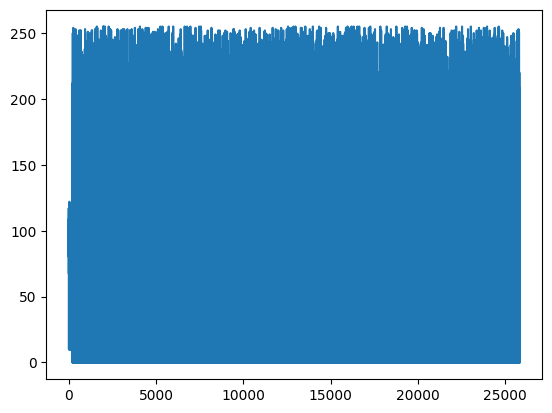

In [23]:
x = range(len(contents))
plt.plot(x, list(contents))
plt.show()

Well, that looks pretty stupid and useless - definitely nothing like a comprehensible frequency spectrum. Note, however, there seems to be a handfull of points on the left side of the plot with much lower amplitude than the rest of the data. Zooming in on the first 500 points:

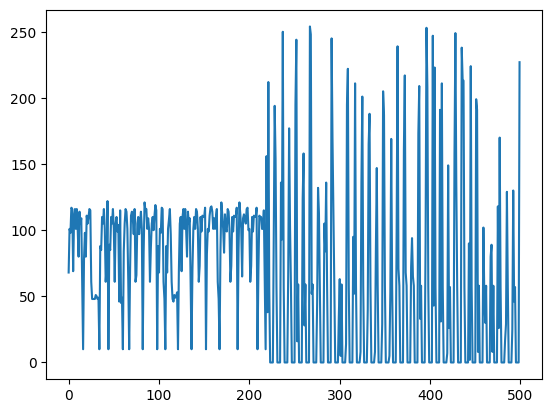

In [24]:
x = x[0:500]
y = list(contents[0:500])
plt.plot(x,y)
plt.show()

Indeed, we do see that the first 200+ points are significantly lower-amplitude than the rest. At this point, we're not really sure what the significance of this is, but it's certainly worth noting.

Let's take a look at the values themselves around here and see if we can't tease out some kind of pattern.



In [25]:
print(y)

[68, 101, 98, 117, 116, 69, 110, 116, 101, 116, 101, 80, 114, 105, 109, 61, 10, 78, 98, 80, 111, 105, 110, 116, 115, 61, 48, 48, 48, 48, 51, 50, 48, 49, 10, 88, 85, 110, 105, 116, 101, 61, 72, 122, 10, 89, 85, 110, 105, 116, 101, 61, 105, 110, 99, 104, 46, 115, 45, 49, 10, 84, 105, 116, 114, 101, 61, 10, 70, 111, 114, 109, 97, 116, 61, 66, 105, 110, 97, 105, 114, 101, 10, 83, 121, 115, 116, 101, 109, 101, 61, 87, 105, 110, 100, 111, 119, 115, 10, 88, 68, 101, 98, 117, 116, 61, 48, 10, 88, 68, 101, 108, 116, 97, 61, 48, 46, 51, 49, 50, 53, 10, 70, 105, 110, 69, 110, 116, 101, 116, 101, 80, 114, 105, 109, 61, 10, 70, 101, 110, 101, 116, 114, 101, 61, 73, 110, 99, 111, 110, 110, 117, 10, 82, 101, 99, 111, 117, 118, 114, 101, 109, 101, 110, 116, 61, 48, 10, 84, 121, 112, 101, 83, 112, 101, 99, 116, 114, 101, 61, 73, 110, 99, 111, 110, 110, 117, 10, 84, 121, 112, 101, 65, 109, 112, 108, 105, 116, 117, 100, 101, 61, 73, 110, 99, 111, 110, 110, 117, 10, 68, 111, 110, 110, 101, 101, 115, 61, 1

Scrolling through this data, a basic pattern does jump out: right around the 200-somethingth data point, we see that the data appears to be organized into groups of eight points; four non-zero integers followed by four zeros. Interesting.

Worth noting, the ACOEM manual mentions there are two data channels available for simultaneous measurements. We're obviously only using one channel, so it's possible we're looking at 8-element data points where the first four elements are channel 1 data and the second 4 elements are channel 2 data.

The first 200-some-odd points are probably significant - possibly some kind of scaling or calibration information - but for now, I'm going ignore them and focus instead on the rest of the data. Let's figure out just where we need to slice our data set to exclude these first, lower-amplitude points.

In [26]:
zero_ind = y.index(0,0)

So, the first `0` occurs at the 223rd index of our data. Assuming our 8-element data points do indeed begin with four non-zero elements (as opposed to starting with four zeros), we'll count back from 223 to include the preceding four non-zero integers in our retained dataset.

In [27]:
data = list(contents[(zero_ind - 4):])
len(data)

25608

Here's where we get a few goosebumps. Note that we just lopped 219 points off our orignial data set which was 25,827 points long:

$25,827 - 219 = 25,608$

Now, that's interesting, because:

$\frac{25,608}{3201} = 8$

That's right, *exactly* eight.

So, it would seem that, starting at point 219 of the original dataset, every group of 8 integers somehow represents a single vibration amplitude value. There are 3201 of these points. Each point represents velocity amplitude at $0.3125 \times n$ Hz.

## Why Four Integers per Data Point?

Let's break our 25,827 integers into groups of eight and look at some basic stats:

In [28]:
for i in range(0,8):
  print(f"bit {i}: min: {min(data[i::8])}, max: {max(data[i::8])}, mean: {np.mean(data[i::8])}, stdd: {np.std(data[i::8])}")

bit 0: min: 0, max: 255, mean: 128.48234926585442, stdd: 74.09427122698334
bit 1: min: 0, max: 255, mean: 128.27116526085598, stdd: 73.55984293854824
bit 2: min: 0, max: 255, mean: 122.02936582318026, stdd: 75.55344324720191
bit 3: min: 54, max: 62, mean: 55.56794751640113, stdd: 0.7662580064529305
bit 4: min: 0, max: 0, mean: 0.0, stdd: 0.0
bit 5: min: 0, max: 0, mean: 0.0, stdd: 0.0
bit 6: min: 0, max: 0, mean: 0.0, stdd: 0.0
bit 7: min: 0, max: 0, mean: 0.0, stdd: 0.0


Hey, it's a base 256 number system! check this out:

https://consciousvibes.com/wp/wp-content/uploads/2018/09/ConvertingToBase256FromDecimal.pdf

Interestingly, this linked info is about IPv4 addresses. The four octals actually represent a single, large number. Look at the link for more info.

Now let's write a quick function to do what we see in the link above. Essentially, our four integers are the coefficients of a third-degree polynomial:

$w 256^3 + x 256^2 + y 256 + z = Amplitude \times 2^{32}$

... assuming 32-bit measurement resolution. This is a bit of a discrepancy, since the ACOEM manual mentions 24-bit measurement resolution, and dividing the left-hand side by $2^{24}$ doesn't really get us in the ballpark amplitude-wise the way $2^{32}$ does.



In [29]:
def four_elm_word(four_elm_list,endianness="little"):
  if endianness == "big":
    w = four_elm_list[0]
    x = four_elm_list[1]
    y = four_elm_list[2]
    z = four_elm_list[3]
  elif endianness == "little":
    w = four_elm_list[3]
    x = four_elm_list[2]
    y = four_elm_list[1]
    z = four_elm_list[0]
  else:
    print("Endianness can only be big or little. Exiting.")
    return

  return w*256**3 + x*256**2 + y*256 + z

# Now Decode All 3201 Points and Plot

First, we'll need to store our data as a numpy array so that we can reshape it into the 8-element, 2-channel format we've discovered. Then we can loop through each 8-element point, and apply our `four_elm_word()` function to the first channel data in each point.

In [30]:
# reshape data to 3201 x 2 x 4
dat = np.array(data)
dat = dat.reshape((len(data)//8,2,4))

In [31]:
d = []
for n in dat:
  data_point = four_elm_word(n[0],endianness="little")
  d.append(data_point/2**32)

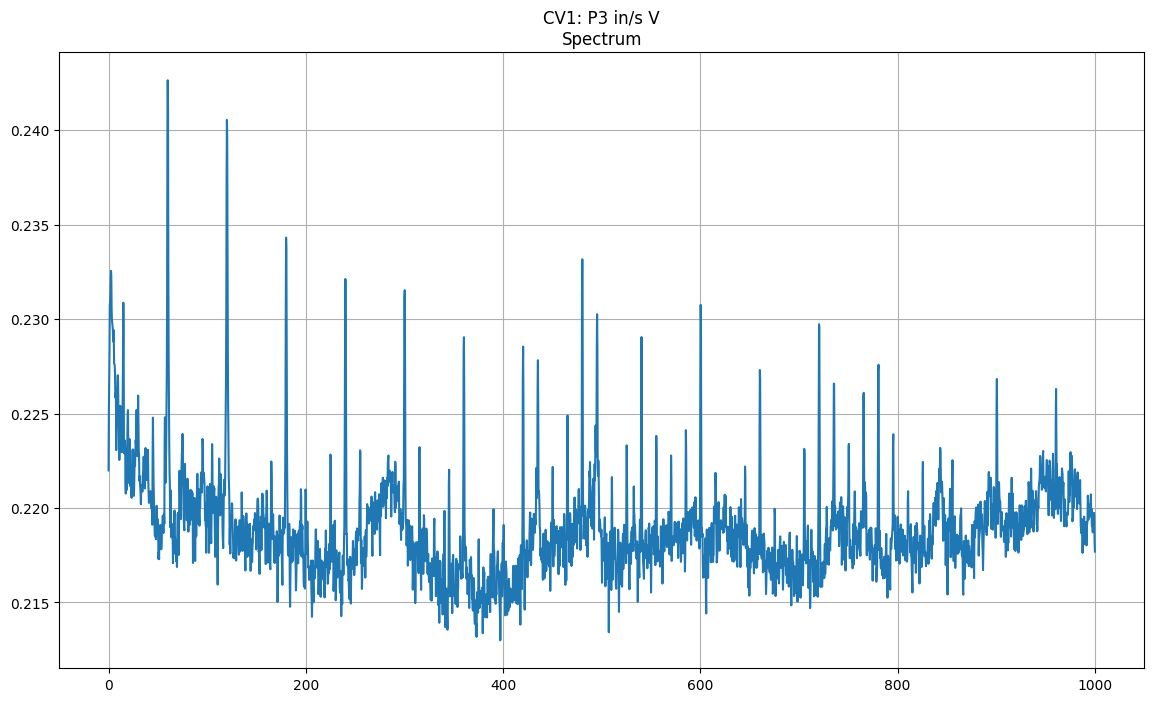

In [32]:
dx = 0.3125 #from header info
x0 = 0      #from header info
Hz = np.arange(x0,len(d)*dx,dx)

#plot it
plt.figure(figsize=(14,8))
plt.plot(Hz, d)
plt.grid()
plt.title(f'{measurement_location(con, equipment_index(con, signal))}\n{signal_type(con, signal)}')
plt.show()

oh, hello there. :D

Compare to handheld display (with y-axis set to Log inch/s Peak, and x-axis set to Hz (not CPM)), and you're pretty close. There seems to be a bit of a scaling factor... The fundamental frequency at 60 Hz is at 0.217 inch/s on the ACOEM handheld, whereas here, we're seeing something around 0.242 inch/s. But overall, the shape of that spectrum is identical to what's on the ACOEM. Success!

In [33]:
max(d)

0.24263694556429982

# NOTES

## From the ACOEM Manual

* 100 mV / g
* up to 80 g (... +/- 80 g?)

## Scratch Notes...

Note:

1. No value exceeds 256. This seems significant. All are integers. Somehow,these eight integer values per point have got to come together to make something a little more meaningful. ACOEM literature says 24-bit sampling? Yes, on page 4 of 18: "24-bit conversion"... which is:

$2^{24} = 16,777,216$

or:

$-8,388,607$ to $+8,388,607$

increments. So, from the manual, we have:

$100 mV / g$

and a maximum of $80 g$ (... is that +/-80 g?)

Assuming that's +/- 80 g, -8,388,607 corresponds to -80 g (-8V at the transducer) and opposite for the positive end...

Oh, I think maybe it's big or little endian bit mapping...

you have eight values in a point, each of which is an integer from 0 to 255. Each integer is a bit in an 8-bit byte.

Ok, but they're all *positive* integers - right - remember this is *already* a frequency spectrum! These bytes represent $in/s$ amplitudes at a given frequency, not $g$ forces at a given moment in time!!

note:

1. $256 \times 256 \times 256 = 16,777,216$ ... so, then do we only need 3 of the 8 integers? what about the rest? also, how would we combine, say, [156, 38, 212, 56, 0, 0, 0, 0], which happens to be the first set of 8 integers in `data`...?

$156/256 + 38/256 + 212/256 + 56/256 = ...?$

No! The order must matter...

2. $256 \times 8 = 2048$ ... so, that doesn't seem like it's what it is...




In [34]:
# Numerical Integration of Accelerometer Data...

def trapz(data):
  ncols, nrows = data.shape[0], data.shape[1]
  if ncols < 2:
    print("Error. At least 2 data columns required")
    return

  t = data[0,:] #first column must be time
  res = np.zeros_like(data) #pre-allocate array to hold results
  res[0,:] = t

  for col in range(1, ncols):
    y = data[col,:] #x,y,z... as we iterate...

    Y = np.zeros_like(y)

    for i in range(1, nrows-1):
      Y[i] = Y[i-1] + (y[i+1] + y[i])/2 * (t[i+1] - t[i])

    bias = np.mean(Y)

    res[col,:] = Y - bias #had to include this to move sinusoids up/down

  return res

In [35]:
# T = np.linspace(0,t,data.size)
# ACCEL = np.array([T,data])

# VEL = trapz(ACCEL)